In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import openml
import pandas as pd
import json
import pickle
import sys
sys.path.append("..")

In [2]:
names = {
    "HAverage": "HAverage",
    "KPrototypes": "K-Prototypes",
}

baseline_pairs = {
    "HAverage": "manhattan_hamming",
    "KPrototypes": "sqeuclidean_hamming"
}

train_res_files = {name: f"data/{name}/training_results.pickle" for name in names}
times_file = {name: f"data/{name}/benchmark_times.json" for name in names}
meta_feat_times = "data/meta_features_times.json"

In [6]:
openml_df = openml.datasets.list_datasets(output_format="dataframe")
df = openml_df[openml_df.NumberOfNumericFeatures >= 1]

df = df[df.NumberOfInstances >= 50]
df = df[df.NumberOfSymbolicFeatures >= 2]
df = df[df.NumberOfMissingValues == 0]
df = df[df.NumberOfClasses > 0]
df = df[df.NumberOfClasses < 100]
df = df[df.version == 1]
n_matching_datasets = len(df)
dict_ = {"NumberOfFeatures":"Features", "NumberOfInstances": "Instances", "NumberOfNumericFeatures":"Num. Features", "NumberOfSymbolicFeatures": "Cat. Features", "NumberOfClasses": "Classes"}
df= df.rename(columns=dict_)

tasks = openml.tasks.list_tasks(task_type=openml.tasks.TaskType.CLUSTERING, output_format="dataframe")
datasets_used_for_clustering = np.unique(tasks.did.values)

selected_datasets = pd.read_csv("data/selected_datasets.csv", sep=" ", index_col="id")
df = df.loc[[v for v in selected_datasets.index if v in datasets_used_for_clustering]]

print("Description of selected data sets:")
df[dict_.values()].describe().astype(int)

c:\Users\abdou\Documents\Workspace\Recherche\simrec\venv\lib\site-packages\openml\utils.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(new_batch, ignore_index=True)


Description of selected data sets:


,Features,Instances,Num. Features,Cat. Features,Classes
count,84,84,84,84,84
mean,51,190674,39,12,5
std,180,385884,177,17,7
min,3,50,1,2,2
25%,9,202,3,3,2
50%,17,979,7,5,3
75%,33,37176,18,16,5
max,1637,1455525,1599,137,48


In [7]:
with open(meta_feat_times, "r") as f:
    durations = json.load(f)
    durations = {k: v for k, v in durations.items() if int(k.split("_")[0]) in datasets_used_for_clustering}
    total_time = max(sum(durations.values())/64, max(durations.values()))
    print("Meta-features extraction:\t", str(timedelta(seconds=total_time)))

for name, filename in times_file.items():
    with open(filename, "r") as f:
        durations = json.load(f)
        durations = {k: v for k, v in durations.items() if int(k.split("_")[0]) in datasets_used_for_clustering}
        total_time = max(sum(durations.values())/64, max(durations.values()))
        print(f"Benchmark {names[name]}:\t\t", str(timedelta(seconds=total_time)))

Meta-features extraction:	

 1:23:43.035210
Benchmark HAverage:		 7:29:00.726354
Benchmark K-Prototypes:		 4 days, 20:30:58.643479


In [3]:
train_res = {}
for algo, train_res_file in train_res_files.items():
    with open(train_res_file, "rb") as f:
        train_res[algo] = pickle.load(f)

In [4]:
from meta_learners import ndcg
from scipy.stats import kendalltau, spearmanr

ndcg_ranks = [5, 10, 20]
n_bests = [1, 5, 10]
np.random.seed(0)
results = {}
for algo, t in train_res.items():
    Y = t["Y"]
    Yn = np.array([y/max(y[y>0]) for y in Y])
    Yn[Yn>0] **= 4
    Yn[Yn<0] = -1
    results[algo] = {}
    results[algo]["proposed"] = {}
    results[algo]["ARB"] = {}
    results[algo]["ARB"]["ndcg"] = {k:[] for k in ndcg_ranks}
    results[algo]["ARB"]["kendall"] = []
    results[algo]["ARB"]["scores"] = {k:[] for k in n_bests}
    results[algo]["ARB"]["posbest"] = []
    results[algo]["LB"] = {}
    results[algo]["LB"]["scores"] = []
    results[algo]["RB"] = {}
    results[algo]["RB"]["scores"] = []
    results[algo]["Best"] = {}
    results[algo]["Best"]["scores"] = []
    print(f"{algo}:", len(t["train_results"]))
    for split, res in t["train_results"].items():
        train_index, test_index = res["train_index"], res["test_index"]
        Y_train, Y_test = Y[train_index], Y[test_index]
        Yn_train, Yn_test = Yn[train_index], Yn[test_index]
        for model_name, Y_pred in res["predictions"].items():
            if model_name not in results[algo]["proposed"]:
                results[algo]["proposed"][model_name] = {}
                results[algo]["proposed"][model_name]["ndcg"] = {k:[] for k in ndcg_ranks}
                results[algo]["proposed"][model_name]["kendall"] = []
                results[algo]["proposed"][model_name]["scores"] = {k:[] for k in n_bests}
                results[algo]["proposed"][model_name]["posbest"] = []
            for p in ndcg_ranks:
                results[algo]["proposed"][model_name]["ndcg"][p].append(ndcg(Yn_test, Y_pred, p=p))
            for k in n_bests:
                results[algo]["proposed"][model_name]["scores"][k].append(np.array(
                    [max(y[y > 0][np.argsort(-Y_pred[i][y > 0])[:k]]) for i, y in enumerate(Y_test)]
                ))

        ar = np.array([np.mean([v for v in Y_train[[i for i, ind in enumerate(train_index) \
            if t["ids"][ind].split("_")[1]=='0'], j]]) for j in range(Y_train.shape[1])])
        for p in ndcg_ranks:
            results[algo]["ARB"]["ndcg"][p].append(ndcg(Yn_test, np.array([ar for _ in Y_test]), p=p))
        for k in n_bests:
            results[algo]["ARB"]["scores"][k].append(np.array(
                [max(y[y > 0][np.argsort(-ar[y > 0])[:k]]) for y in Y_test]))
                
        sim_pairs_index = dict(zip(t["similarity_pairs"], range(len(t["similarity_pairs"]))))
        results[algo]["LB"]["scores"].append(Y_test[:, sim_pairs_index[baseline_pairs[algo]]])
        results[algo]["RB"]["scores"].append([np.mean(np.random.choice(y[y>0], size=10, replace=True)) for y in Y_test])
        results[algo]["Best"]["scores"].append(np.max(Y_test, axis=1))

HAverage: 36
KPrototypes: 31


In [5]:
obj = {}
model_names = ["KNN", "PR-DTree"]
print("top-k accuracy for different values of k")
for algo in results:
    Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
    ids = np.concatenate([train_res[algo]["ids"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
    l = [(max(y[y>0]) - np.quantile(y[y>0], 0.5)) for i, y in enumerate(Y) if ids[i].split("_")[1] == '0']
    x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
    x[0] -= 1e-4
    best_scores = np.concatenate(results[algo]["Best"]["scores"])
    for name in ["LB", "RB"]:
        if name not in obj:
            obj[name] = {}
        l = np.concatenate(results[algo][name]["scores"])/best_scores
        obj[name][f"({algo[0]}) top-01"] = \
            f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"
    
    if "ARB" not in obj: obj["ARB"] = {}
    for k in [1, 5, 10]:
        l = np.concatenate(results[algo]["ARB"]["scores"][k])/best_scores
        obj["ARB"][f"({algo[0]}) top-{k:02d}"] = \
            f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

    for model_name in model_names:
        if model_name not in obj:
            obj[model_name] = {}
        for k in [1, 5, 10]:
            l = np.concatenate(results[algo]["proposed"][model_name]["scores"][k])/best_scores
            obj[model_name][f"({algo[0]}) top-{k:02d}"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

pd.DataFrame.from_dict(obj, orient="index")[sorted(obj["ARB"])]

top-k accuracy for different values of k


,(H) top-01,(H) top-05,(H) top-10,(K) top-01,(K) top-05,(K) top-10
LB,0.937±0.08,NaN,NaN,0.837±0.13,NaN,NaN
RB,0.929±0.08,NaN,NaN,0.853±0.09,NaN,NaN
ARB,0.908±0.1,0.932±0.09,0.940±0.09,0.874±0.12,0.930±0.11,0.937±0.11
KNN,0.960±0.06,0.969±0.06,0.977±0.05,0.894±0.11,0.922±0.11,0.944±0.08
PR-DTree,0.953±0.06,0.971±0.06,0.987±0.03,0.905±0.1,0.936±0.09,0.956±0.08


[12, 12, 12]


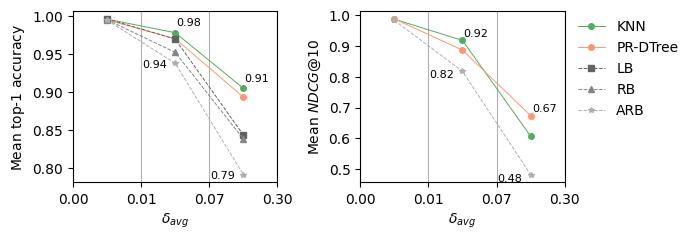

[11, 10, 10]


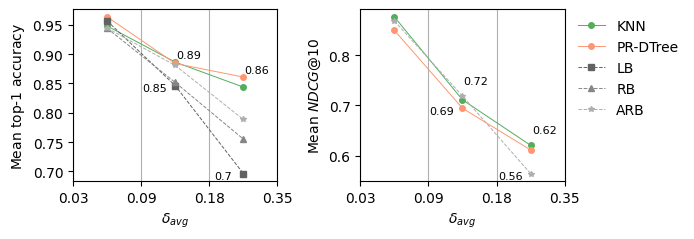

In [7]:
def show_results_delta(results, savedir=None, list_algo=None):
    model_names = ["KNN", "PR-DTree"]

    colors = {
        "PR-DTree": "#FF9671",
        "KNN": "#52AD5D",
        "LB": "#626262",
        "RB": "#868686",
        "ARB": "#AFAFAF"
    }

    linestyle = {
        "PR-DTree": "-o",
        "KNN": "-o",
        "LB": "--s",
        "RB": "--^",
        "ARB": "--*"
    }

    j = 0
    for algo in (list_algo if list_algo is not None else results):
        
        Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
        ids = np.concatenate([train_res[algo]["ids"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
        res = results[algo]
        plt.figure(figsize=(6, 2.5))
        
        best_scores = np.concatenate(res["Best"]["scores"])
        lb_scores = np.concatenate(res["LB"]["scores"])
        l = [np.mean((max(y[y>0]) - y[y>0])/max(y[y>0])) for i, y in enumerate(Y) if ids[i].split("_")[1] == '0']
        x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
        
        x[0] -= 1e-4
        diff = 0.025
        list_indices = [
            [xr < np.mean((max(y[y>0]) - y[y>0])/max(y[y>0])) <= x[r+1] and ids[i].split("_")[1] == '0' for i, y in enumerate(Y)]
            for r, xr in enumerate(x[:-1])
        ] #

        plt.subplot(1, 2, 1)
        k=1
        baselines = ["LB", "RB", "ARB"]
        y = {}
        yerr = {}
        print([sum(indices) for indices in list_indices])
        for model_name in model_names:
            y[model_name] = []
            yerr[model_name] = []
            scores = np.concatenate(res["proposed"][model_name]["scores"][k])
            for i, indices in enumerate(list_indices):
                l = ((scores)/best_scores)[indices]
                v = np.mean(l)
                std = np.std(l)
                y[model_name].append(v)
                yerr[model_name].append(std)

        for name in baselines:
            y[name] = []
            yerr[name] = []
            for i, indices in enumerate(list_indices):
                scores = np.concatenate(res[name]["scores"][k] if name in ["ARB"] else res[name]["scores"])
                l = ((scores)/best_scores)[indices]
                v = np.mean(l)
                std = np.std(l)
                y[name].append(v)
                yerr[name].append(std)

        n_bar = len(y)
        w = 0.8/n_bar
        z = np.arange(len(x))
        i = 0
        max_ = np.zeros(len(list_indices))
        min_ = np.ones(len(list_indices))*100
        for model_name, values in y.items():
            max_ = np.maximum(max_, values)
            min_ = np.minimum(min_, values)
            plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=model_name, markersize=4, zorder=10)
            i += 1

        for ind, val in enumerate(list_indices):
            if ind >= 1:
                plt.annotate(f"{max_[ind]:.2g}", (z[ind]+0.7, max_[ind]+0.02), fontsize=8, ha="center", va="top")
                plt.annotate(f"{min_[ind]:.2g}", (z[ind]+0.2, min_[ind]+0.005), fontsize=8, ha="center", va="top")

        plt.xlim((z[0], z[-1]))
        plt.ylabel(f"Mean top-${k}$ accuracy")
        plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
        plt.grid(axis="x")
        plt.xlabel("$\delta_{avg}$")



        plt.subplot(1, 2, 2)
        k=10
        baselines = ["ARB"]
        y = {}
        for model_name in model_names:
            y[model_name] = []
            l_ = res["proposed"][model_name]["ndcg"][k]
            for i, indices in enumerate(list_indices):
                l = np.concatenate(l_)[indices]
                y[model_name].append(np.mean(l))

        for name in baselines:
            y[name] = []
            l_ = res[name]["ndcg"][k]
            for i, indices in enumerate(list_indices):
                l = np.concatenate(l_)[indices]
                y[name].append(np.mean(l))

        n_bar = len(y)
        w = 0.8/n_bar
        z = np.arange(len(x))
        i = 0
        max_ = np.zeros(len(list_indices))
        min_ = np.ones(len(list_indices))
        for model_name, values in y.items():
            max_ = np.maximum(max_, values)
            min_ = np.minimum(min_, values)
            plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], markersize=4, zorder=10)
            i += 1
        
        for ind, val in enumerate(list_indices):
            if ind >= 1:
                plt.annotate(f"{max_[ind]:.2g}", (z[ind]+0.7, max_[ind]+0.04), fontsize=8, ha="center", va="top")
                plt.annotate(f"{min_[ind]:.2g}", (z[ind]+0.2, min_[ind]+0.005), fontsize=8, ha="center", va="top")

        plt.xlim((z[0], z[-1]))
        plt.ylabel(f"Mean $NDCG@{k}$")
        plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
        plt.grid(axis="x")
        plt.xlabel("$\delta_{avg}$")

        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.95, 0.95), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{algo}.pdf"), bbox_inches='tight')
            # plt.savefig(os.path.join(savedir, f"results_delta_{algo}.svg"), bbox_inches='tight')
        plt.show()

show_results_delta(results, savedir="imgs/")

[12, 12, 12]
[12, 12, 12]
[12, 12, 12]


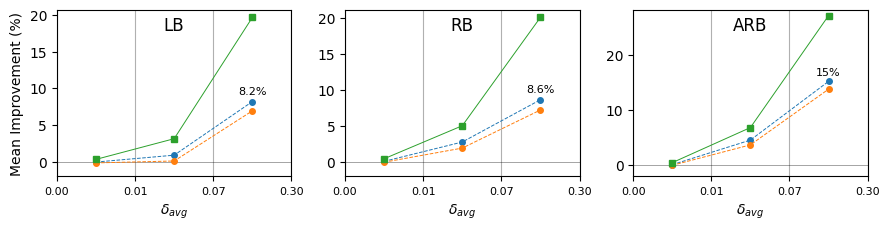

[11, 10, 10]
[11, 10, 10]
[11, 10, 10]


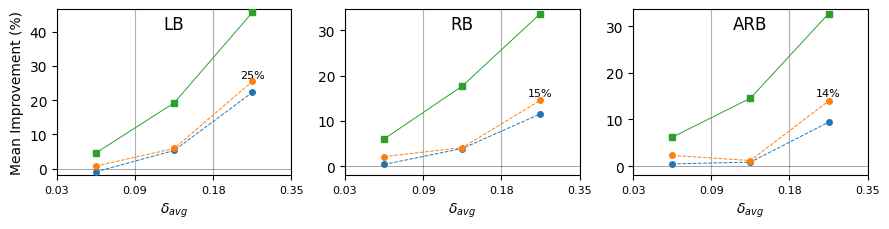

In [12]:
def show_imp_baselines_delta(results, k=1, savedir=None, list_algo=None):
    baselines = ["LB", "RB", "ARB"]
    model_names = ["KNN", "PR-DTree"]
    for algo in (list_algo if list_algo is not None else results):
        res = results[algo]
        fig = plt.figure(figsize=(len(baselines)*3, 2.4))
        for j, name in enumerate(baselines):
            plt.subplot(1, len(baselines), j+1)
            baseline_scores = np.concatenate(res[name]["scores"][k] if name in ["ARB"] \
                else res[name]["scores"])
            y = {}
            Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
            ids = np.concatenate([train_res[algo]["ids"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
            l = [np.mean((max(y[y>0]) - y[y>0])/max(y[y>0])) for i, y in enumerate(Y) if ids[i].split("_")[1] == '0']
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean((max(y[y>0]) - y[y>0])/max(y[y>0])) <= x[r+1] and ids[i].split("_")[1] == '0' for i, y in enumerate(Y)]
                for r, xr in enumerate(x[:-1])
            ] #
            print([sum(indices) for indices in list_indices])

            for model_name in model_names:
                y[model_name] = []
                scores = np.concatenate(res["proposed"][model_name]["scores"][k])
                for i, indices in enumerate(list_indices):
                    v = np.mean(((scores-baseline_scores)/baseline_scores)[indices])
                    y[model_name].append(v*100)

            y["Oracle"] = []
            for i, indices in enumerate(list_indices):
                scores = np.concatenate(res["Best"]["scores"])
                v = np.mean(((scores-baseline_scores)/baseline_scores)[indices])
                y["Oracle"].append(v*100)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            for model_name, values in y.items():
                if model_name != "Oracle":
                    max_ = np.maximum(max_, values)
                plt.plot(z[:-1]+0.5, values, "--o" if model_name!="Oracle" else "-s", linewidth=0.7, label=model_name if j==0 else None, markersize=4, alpha=1, zorder=10)
                i += 1

            for ind, val in enumerate(list_indices):
                if ind > 1:
                    plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center")

            plt.xlim((z[0], z[-1]))
            
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x], fontsize=8)
            plt.ylim((-2., max(y["Oracle"])+1))
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.axhline(color="black", linewidth=0.5, alpha=0.5)
            if j == 0: 
                plt.ylabel("Mean Improvement (%)")                
            plt.title(name, y=0.83)

        if algo=="haverage": plt.figlegend(fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+1)
        plt.tight_layout(w_pad=1)
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"imp_baselines_delta_{algo}.pdf"), bbox_inches='tight')
        plt.show()

show_imp_baselines_delta(results)

In [13]:
from scipy.stats import wilcoxon, ttest_rel

model_names = ["KNN", "PR-DTree"]
baselines = ["LB", "RB", "ARB"]
y = {k:{} for k in model_names}
y_ndcg = {k:{} for k in model_names}
for algo, res in results.items():    
    for model_name in model_names:
        for name in baselines:
            baseline_scores = np.concatenate(res[name]["scores"][1] if name=="ARB" else res[name]["scores"])
            scores = np.concatenate(res["proposed"][model_name]["scores"][1])
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y[model_name][f"({algo[0]}-A){name}"] = f"{p:.3f}"

        baseline_scores = np.concatenate(res["ARB"]["ndcg"][10])
        scores = np.concatenate(res["proposed"][model_name]["ndcg"][10])
        s, p = wilcoxon(scores, baseline_scores, alternative="greater")
        y[model_name][f"({algo[0]}-N){name}"] = f"{p:.3f}"

print(pd.DataFrame.from_dict(y, orient='index'))

         (H-A)LB (H-A)RB (H-A)ARB (H-N)ARB (K-A)LB (K-A)RB (K-A)ARB (K-N)ARB
KNN        0.012   0.004    0.000    0.000   0.029   0.007    0.084    0.431
PR-DTree   0.434   0.016    0.003    0.000   0.015   0.011    0.124    0.439


c:\Users\abdou\Documents\Workspace\Recherche\simrec\venv\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
